<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/nbody_binned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install --quiet mediapy tensor-canvas

In [25]:
import jax.numpy as jnp
from jax import jit
from jax import vmap
import jax
from numpy import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorcanvas as tc
from mediapy import VideoWriter

In [26]:
def draw_sim(parts_pos, parts_vel, grid_r, opacity=1.0, p_size=4.0):
  canvas = jnp.zeros((grid_r, grid_r, 3))
  col = opacity*jnp.array([1.0,0.0,0.0])
  # would be interesting to use jax.experimental.loops for these
  for part_p, part_v in zip(parts_pos, parts_vel):
    canvas = tc.draw_circle(part_p[0]*grid_r, part_p[1]*grid_r, p_size, col, canvas)
  return canvas

In [27]:
def draw_sim_par(parts_pos, parts_vel, grid_r, opacity=1.0, p_size=4.0):
  col = opacity*jnp.array([1.0,0.0,0.0])
  draw_single = lambda part_p, canv: tc.draw_circle(part_p[0]*grid_r, part_p[1]*grid_r, p_size, col, canv)
  draw_all = vmap(draw_single)
  return draw_all(parts_pos, jnp.zeros((parts_pos.shape[0], grid_r, grid_r, 3))).sum(0)

In [28]:
def compute_forces(pos, scale, eps=0.1):
  a, b = jnp.expand_dims(pos, 1), jnp.expand_dims(pos, 0)
  diff = a - b
  dist = (diff * diff).sum(axis=-1) ** 0.5
  dist = jnp.expand_dims(dist, 2)
  force = diff / ((dist * scale) ** 3 + eps)
  return force.sum(0)

fast_compute_forces = jit(compute_forces)

In [96]:
def compute_forces_sparse(pos, scale, eps=0.1):
  # calculate bin for each particle
  bin_size = 0.05
  min_x, min_y = -5, -5
  max_x, max_y = 5, 5
  lower_bound = jnp.array([min_x,min_y])
  bin_scale = 1 / bin_size
  total_bins = int( (max_x - min_x) * bin_scale * (max_y - min_y) * bin_scale )
  pos_trunc = jnp.floor((pos - lower_bound) * bin_scale).astype('int32')
  num_cols = jnp.array(bin_scale * (max_x - min_x)).astype('int32')
  num_rows = jnp.array(bin_scale * (max_y - min_y)).astype('int32')
  particle_bins = pos_trunc[:, 0] * num_cols + pos_trunc[:, 1]
  bin_counts = jnp.bincount(particle_bins, length=total_bins)
  bin_offsets = jnp.cumsum(bin_counts)
  # assert bin_counts.shape == bin_offsets.shape

  # sort particle data by bin
  sorted_indices = jnp.argsort(particle_bins)
  sorted_pos = pos[sorted_indices]

  def single_particle_calc_force(pos_this, pos_other):
    diff = pos_this - pos_other
    dist = (diff * diff).sum() ** 0.5
    force = diff / ((dist * scale) ** 3 + eps)
    return force

  # impl particle to force func using jax loops
  def compute_all_forces_for_bin(bin_start_idx, bin_count, self_idx, sorted_pos):
    init_force = jnp.zeros_like(sorted_pos[0])
    self_pos = sorted_pos[self_idx]
    def body_fun(cur_idx, total_bin_force):
      other_pos = sorted_pos[cur_idx]
      #if cur_idx != self_idx: # TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
        #total_bin_force = total_bin_force + single_particle_calc_force(self_pos, sorted_pos[cur_idx])
      return total_bin_force + single_particle_calc_force(self_pos, other_pos)
    return jax.lax.fori_loop(bin_start_idx, bin_start_idx + bin_count, body_fun, init_force)

  def accum_forces_for_all_adjacent_bins(index, sorted_pos):
    # for each adjacent bin
    self_pos = sorted_pos[index]
    self_pos_trunc = jnp.floor((self_pos - lower_bound) * bin_scale).astype('int32')
    self_bin_x = self_pos_trunc[0]
    self_bin_y = self_pos_trunc[1]

    total_force = jnp.zeros_like(sorted_pos[0])

    for x_offset in [-1, 0, 1]:
      for y_offset in [-1, 0, 1]:
        bin_x = self_bin_x + x_offset
        bin_y = self_bin_y + y_offset
        #if 0 <= bin_x < num_cols and 0 <= bin_y < num_rows:
        bin_idx = bin_x * num_cols + bin_y
        total_force += compute_all_forces_for_bin(bin_offsets[bin_idx], bin_counts[bin_idx], index, sorted_pos)

    return total_force

  #return accum_forces_for_all_adjacent_bins(0, sorted_pos)
  # vmap that func and return that result
  return vmap(accum_forces_for_all_adjacent_bins, in_axes=(0, None))(jnp.arange(pos.shape[0]), sorted_pos)

In [97]:
test_input = make_init_state(4)[0]

In [98]:
test_input.shape

(4, 2)

In [99]:
#test_input
compute_forces_sparse(jnp.array(test_input), 1.0, eps=0.1)

Array([[-1.2109973 , -0.62288237],
       [-1.2559643 ,  0.8570188 ],
       [-0.08379591, -1.2508986 ],
       [ 0.        ,  0.        ]], dtype=float32)

In [108]:
def sim_update_force(parts_pos, parts_vel, t_delta=0.05, scale=5, repel_mag=0.1, center_mag=2.5, steps=10, damp=0.99):
  p_p = jnp.array(parts_pos)
  p_v = jnp.array(parts_vel)
  # jax.experimental.loops
  for _ in range(steps):
    p_p = p_p + t_delta * p_v
    force = fast_compute_forces(p_p, scale) # compute_forces_sparse(p_p, scale)#
    center_diff = p_p-0.5
    centering_force = center_diff / ((center_diff ** 2).sum() ** 0.5)
    p_v = damp * p_v - t_delta * (force * repel_mag + centering_force * center_mag)
  return p_p, p_v

In [109]:
def make_init_state(p_count):
  return random.rand(p_count, 2), random.rand(p_count, 2)-0.5

In [110]:
fast_draw = jit(draw_sim, static_argnums=(2,))
fast_draw_par = jit(draw_sim_par, static_argnums=(2,))
fast_sim_update_force = jit(sim_update_force, static_argnames=('steps'))

100%|██████████| 1000/1000 [00:01<00:00, 737.55it/s]


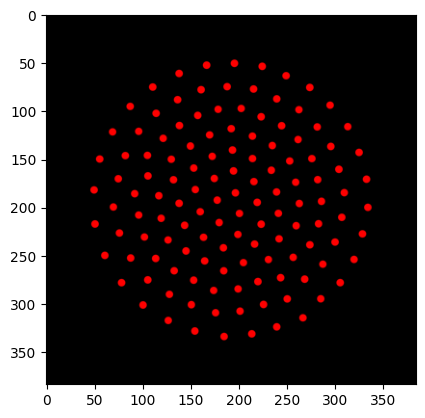

In [111]:
p_state, v_state = make_init_state(128)
v_state *= 0
grid_res = 384
for i in tqdm(range(1000)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, p_size=4.0))

100%|██████████| 100/100 [00:01<00:00, 96.04it/s]


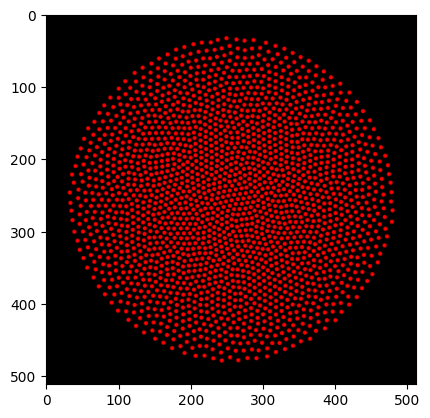

In [112]:
p_state, v_state = make_init_state(2048)
v_state *= 0
grid_res = 512
for i in tqdm(range(100)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=40, center_mag=0.5, repel_mag=0.05, damp=0.997, steps=20)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, p_size=3.0))


In [113]:
render_video = True

In [14]:
if render_video:
  p_state, v_state = make_init_state(128)
  v_state *= 0
  grid_res = 384
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)

100%|██████████| 1000/1000 [00:10<00:00, 95.25it/s]


In [15]:
if render_video:
  p_state, v_state = make_init_state(512)
  v_state *= 0
  grid_res = 256
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, opacity=0.5, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=20, center_mag=0.5, repel_mag=0.05, damp=0.998, steps=4)

100%|██████████| 1000/1000 [00:09<00:00, 104.72it/s]


In [16]:
!nvidia-smi

Mon Jan 27 21:49:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0              29W /  70W |  11447MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
p_test = 50
res_test = 512

In [18]:
%%timeit
draw_sim(*make_init_state(p_test), res_test)

1.05 s ± 435 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
draw_sim_par(*make_init_state(p_test), res_test)

The slowest run took 8.18 times longer than the fastest. This could mean that an intermediate result is being cached.
68.6 ms ± 52.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
fast_draw(*make_init_state(p_test), res_test)

257 µs ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
fast_draw_par(*make_init_state(p_test), res_test)

1.18 ms ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
